# 02 — Shapefile, GeoDataFrame, CRS (WGS84↔ETRS89), Spatial Operations

Cosa imparerai:
1) **Shapefile**: cosa sono i file `.shp/.shx/.dbf/.prj`  
2) **GeoPandas** da zero: import, creazione di un *GeoDataFrame*, `geometry`, `crs`, `.head()/.info()/.columns`.  
3) **CRS/EPSG**: WGS84 vs ETRS89, UTM, 3857, 3035. Convertire **in/da lat‑lon** con `to_crs()`.  
4) **Scaricare ISTAT 2018** dall’archivio e ispezionare i file (colonne, tipi, CRS, geometrie).  
5) **Relazioni e operazioni** di base (una alla volta): `centroid`, `dissolve`, `sjoin`, `overlay`, `touches`.


In [1]:
from pathlib import Path

# Cartella del notebook
NB_DIR = Path(__file__).resolve().parent if "__file__" in globals() else Path.cwd()

# Config lezione
LEZIONE = "data_lezione_02"
YEAR = "2018"

# Radici locali (niente risalita di directory)
DATA_ROOT     = NB_DIR / "data"
DATA_LEZIONE  = DATA_ROOT / LEZIONE
DATA_RAW      = DATA_LEZIONE / "raw" / "istat" / YEAR
DATA_CLEAN    = DATA_LEZIONE / "clean" / "istat"

# Crea cartelle
for p in [DATA_ROOT, DATA_LEZIONE, DATA_RAW, DATA_CLEAN]:
    p.mkdir(parents=True, exist_ok=True)

print("Notebook dir :", NB_DIR)
print("Data root    :", DATA_ROOT)
print("Lezione dir  :", DATA_LEZIONE)
print("Raw ISTAT    :", DATA_RAW)
print("Clean ISTAT  :", DATA_CLEAN)


Notebook dir : /home/ciro/Downloads/Corso_PyQGIS
Data root    : /home/ciro/Downloads/Corso_PyQGIS/data
Lezione dir  : /home/ciro/Downloads/Corso_PyQGIS/data/data_lezione_02
Raw ISTAT    : /home/ciro/Downloads/Corso_PyQGIS/data/data_lezione_02/raw/istat/2018
Clean ISTAT  : /home/ciro/Downloads/Corso_PyQGIS/data/data_lezione_02/clean/istat


## 0) Shapefile

### Cos'è un **ESRI Shapefile**

Un "ESRI Shapefile" è una raccolta di file diversi con lo stesso nome e diverse estensioni.

Le specifiche pubbliche sono per le estensioni:

| estensione | significato | contenuto del file |
| --------- | ------------- | -------------------------------------------------------------------- |
| .shp | shape | le geometrie (punto, linea, poligono) |
| .dbf | database file | gli attributi da associare alle geometrie |
| .shx | shape indices | gli indici per unire le geometrie con gli attributi |
| .prj | projection | la regola per capire il tipo di proiezione usato dalle geometrie |

Per gestire i dati sono _necessari_ 3 file (*.shp, .shx e .dbf*), tuttavia il file *.prj* è cruciale per analizzare i dati insieme ad altre fonti.

È possibile trovare altri tipi di file

maggiori informazioni sono [qui](https://www.esri.com/library/whitepapers/pdfs/shapefile.pdf
)



|geometrie|immagini|
|:--|--:|
|POINT|![](https://upload.wikimedia.org/wikipedia/commons/thumb/c/c2/SFA_Point.svg/51px-SFA_Point.svg.png)|
|LINESTRING|![](https://upload.wikimedia.org/wikipedia/commons/thumb/b/b9/SFA_LineString.svg/51px-SFA_LineString.svg.png)|
|LINEARRING|![](https://raw.githubusercontent.com/napo/geospatial_course_unitn/master/docs/assets/images/linering.png)|
|POLYGON|![](https://upload.wikimedia.org/wikipedia/commons/thumb/3/3f/SFA_Polygon.svg/51px-SFA_Polygon.svg.png)![](https://upload.wikimedia.org/wikipedia/commons/thumb/5/55/SFA_Polygon_with_hole.svg/51px-SFA_Polygon_with_hole.svg.png)
|MULTIPOINT|![](https://upload.wikimedia.org/wikipedia/commons/thumb/d/d6/SFA_MultiPoint.svg/51px-SFA_MultiPoint.svg.png) 
| MULITLINESTRING|![](https://upload.wikimedia.org/wikipedia/commons/thumb/8/86/SFA_MultiLineString.svg/51px-SFA_MultiLineString.svg.png)| 
| MULTIPOLYGON |![](https://upload.wikimedia.org/wikipedia/commons/thumb/3/3b/SFA_MultiPolygon_with_hole.svg/51px-SFA_MultiPolygon_with_hole.svg.png)| 
| GEOMETRYCOLLECTION |![](https://upload.wikimedia.org/wikipedia/commons/thumb/1/1d/SFA_GeometryCollection.svg/51px-SFA_GeometryCollection.svg.png) | 

ref: [WKT](https://en.wikipedia.org/wiki/Well-known_text_representation_of_geometry)

## 1) **GeoPandas** da zero — import e versioni

In [ ]:
from IPython.display import display
import pandas as pd
import geopandas as gpd
import shapely
import matplotlib.pyplot as plt

print("pandas   :", pd.__version__)
print("geopandas:", gpd.__version__)
print("shapely  :", shapely.__version__)

pandas   : 2.2.3
geopandas: 1.0.1
shapely  : 2.0.6


### 1.1 Crea un **GeoDataFrame** mini da lon/lat (punti)

DataFrame (no geometria):


,name,lon,lat
0,A,12.4924,41.8902
1,B,9.1900,45.4642
2,C,14.2681,40.8518


GeoDataFrame creato:


,name,lon,lat,geometry
0,A,12.4924,41.8902,POINT (12.4924 41.8902)
1,B,9.1900,45.4642,POINT (9.19 45.4642)
2,C,14.2681,40.8518,POINT (14.2681 40.8518)


Colonne: ['name', 'lon', 'lat', 'geometry']
Tipi: name          object
lon          float64
lat          float64
geometry    geometry
dtype: object
CRS: EPSG:4326
Geom type: ['Point']


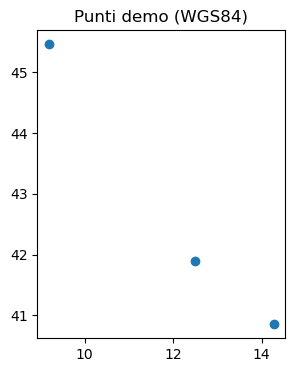

In [4]:
import geopandas as gpd
from shapely.geometry import Point

# Dati tabellari semplici (lon, lat e un nome)
rows = [
    {"name":"A", "lon":12.4924, "lat":41.8902},  # Roma 
    {"name":"B", "lon":9.1900,  "lat":45.4642},  # Milano
    {"name":"C", "lon":14.2681, "lat":40.8518},  # Napoli
]

import pandas as pd
df = pd.DataFrame(rows)
print("DataFrame (no geometria):")
display(df)

# Trasforma in GeoDataFrame con geometria Point (ordine: x=lon, y=lat) e CRS WGS84
gdf_pts = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df["lon"], df["lat"]),
    crs="EPSG:4326"
)

print("GeoDataFrame creato:")
display(gdf_pts.head())
print("Colonne:", list(gdf_pts.columns))
print("Tipi:", gdf_pts.dtypes)
print("CRS:", gdf_pts.crs)
print("Geom type:", gdf_pts.geom_type.unique())

ax = gdf_pts.plot(figsize=(4,4)); ax.set_title("Punti demo (WGS84)"); plt.show()

### 2) **CRS**: Capire le proiezioni e come convertirle

Ogni mappa "appiattisce" la Terra ([truesize.com](https://thetruesize.com/)) in modo diverso. Un Sistema di Riferimento delle Coordinate (CRS) è la regola usata per questo "appiattimento".

Non esiste un CRS "migliore", ma solo il **CRS più adatto allo scopo**. I due tipi principali sono:

#### 1. Sistemi Geografici (usano i gradi)

Misurano la posizione come su un mappamondo, usando **latitudine e longitudine (gradi)**. Sono perfetti per *localizzare* punti, ma pessimi per *misurare* distanze o aree (un grado di longitudine non ha la stessa lunghezza in metri all'Equatore e in Svezia).

* **WGS84 (EPSG:4326)**: Lo standard mondiale, usato da tutti i **GPS**. È il sistema più comune per i dati grezzi.
* **ETRS89 (EPSG:4258)**: L'equivalente europeo di WGS84. Per le nostre analisi, possiamo considerarli quasi identici.

#### 2. Sistemi Proiettati (usano i metri)

Trasformano il mappamondo in una mappa piana, usando i **metri** come unità di misura. Sono fondamentali per calcolare **distanze e aree**.

* **UTM (es. 32N/33N per l'Italia)**: Il sistema "locale" per eccellenza. Divide il mondo in "fette" e appiattisce ogni fetta molto bene. È la scelta migliore per calcolare **distanze e aree precise** su scale regionali o nazionali (es. calcolare l'area di un comune).
    * (L'Italia è divisa tra la Zona 32 Nord - EPSG:32632 e la 33 Nord - EPSG:32633).
* **ETRS-LAEA Europe (EPSG:3035)**: Un sistema "equal-area" per tutta l'Europa. Sacrifica la precisione delle forme, ma garantisce che le **superfici siano corrette e confrontabili**. Ottimo per mappe tematiche che mostrano densità o percentuali a livello europeo.
* **Web Mercator (EPSG:3857)**: Il sistema usato dalle mappe web (Google Maps, OpenStreetMap). È utile per la visualizzazione e la navigazione, ma **NON va usato per analisi**. Deforma enormemente le aree (la Groenlandia sembra grande quanto l'Africa!).


In GeoPandas, si passa da un CRS all'altro con il metodo `.to_crs()`

In [5]:
# Euristica semplice per scegliere una UTM adeguata dai punti
def guess_utm_epsg(lon: float, lat: float):
    zone = int((lon + 180) // 6) + 1
    return 32600 + zone if lat >= 0 else 32700 + zone

lon_mean = float(gdf_pts["lon"].mean())
lat_mean = float(gdf_pts["lat"].mean())
utm_epsg = guess_utm_epsg(lon_mean, lat_mean)
print("UTM suggerita:", utm_epsg)

gdf_pts_utm = gdf_pts.to_crs(utm_epsg)
print("CRS metrico:", gdf_pts_utm.crs)

# Distanza (metri) tra A e B (puramente illustrativa)
if len(gdf_pts_utm) >= 2:
    d = gdf_pts_utm.geometry.iloc[0].distance(gdf_pts_utm.geometry.iloc[1])
    print(f"Distanza A↔B ~ {d/1000:.1f} km")

# Ritorno a lat-lon (WGS84)
gdf_back = gdf_pts_utm.to_crs(4326)
print("Back to WGS84 bounds:", gdf_back.total_bounds)

UTM suggerita: 32632
CRS metrico: EPSG:32632
Distanza A↔B ~ 478.0 km
Back to WGS84 bounds: [ 9.19   40.8518 14.2681 45.4642]


## 3) Scarichiamo ISTAT 2018 (WGS84, generalizzati) dall’archivio
Se non hai rete, inserisci manualmente lo ZIP in `data/raw/istat/2018/` con nome `Limiti01012018_g.zip`.


In [2]:
#Helper upload manuale + estrazione 
from pathlib import Path
import shutil, zipfile

def ensure_zip_available(zip_path: Path, download_url: str, expected_names: list[str]) -> Path:
    """
    Se zip_path non esiste, cerca uno ZIP caricato a mano nei percorsi tipici di Basthon.
    Se non trova nulla: stampa il link da scaricare e chiede di fare Upload, poi interrompe.
    """
    zip_path.parent.mkdir(parents=True, exist_ok=True)

    if zip_path.exists():
        print("ZIP pronto:", zip_path)
        return zip_path

    # Dove Basthon mette i file caricati
    search_dirs = [Path("/home/pyodide"), Path("/home/pyodide/Downloads")]
    for d in search_dirs:
        for n in expected_names:
            cand = d / n
            if cand.exists():
                shutil.copy(cand, zip_path)
                print("Trovato upload:", cand)
                print("ZIP pronto:", zip_path)
                return zip_path

    # Non trovato: istruzioni chiare
    print("⚠️ ZIP mancante.")
    print("Scarica questo file e poi fai Upload in Basthon (icona cartella → Upload):")
    print(" ", download_url)
    print("Dopo l'upload, riesegui questa cella.")
    raise FileNotFoundError(f"Manca lo ZIP. Atteso in {zip_path}")

def extract_zip(zip_path: Path, extract_dir: Path, clean: bool = True) -> Path:
    if clean and extract_dir.exists():
        shutil.rmtree(extract_dir)
    extract_dir.mkdir(parents=True, exist_ok=True)
    with zipfile.ZipFile(zip_path, "r") as z:
        z.extractall(extract_dir)
    print("Estratto in:", extract_dir)
    return extract_dir

In [3]:
# Parametri ISTAT
URL_ISTAT_2018_WGS84_GEN = "https://www.istat.it/storage/cartografia/confini_amministrativi/generalizzati/Limiti01012018_g.zip"
ZIP_PATH = DATA_RAW / "Limiti01012018_g.zip"
EXTRACT_DIR = DATA_RAW / "Limiti01012018_g"

# 1) Richiedi upload manuale usando il link
ensure_zip_available(
    ZIP_PATH,
    download_url=URL_ISTAT_2018_WGS84_GEN,
    expected_names=["Limiti01012018_g.zip"]
)

# 2) Estrazione automatica
extract_zip(ZIP_PATH, EXTRACT_DIR, clean=True)

ZIP pronto: /home/ciro/Downloads/Corso_PyQGIS/data/data_lezione_02/raw/istat/2018/Limiti01012018_g.zip
Estratto in: /home/ciro/Downloads/Corso_PyQGIS/data/data_lezione_02/raw/istat/2018/Limiti01012018_g


PosixPath('/home/ciro/Downloads/Corso_PyQGIS/data/data_lezione_02/raw/istat/2018/Limiti01012018_g')

## 4) Apriamo gli shapefile **uno alla volta** ed esploriamo **gradualmente**

### 4.1 Trova i file candidati (Regioni/Province/Comuni)

In [4]:
#  Trova gli shapefile e prova a individuare regioni/province/comuni
candidates = sorted(EXTRACT_DIR.rglob("*.shp"))
print("Shapefile trovati:", len(candidates))
for p in candidates[:10]:
    print("-", p.relative_to(EXTRACT_DIR))

def pick(names):
    for p in candidates:
        for n in names:
            if n.lower() in p.name.lower():
                return p
    return None

shp_reg = pick(["Reg", "regioni"])
shp_prov = pick(["Prov", "provinc"])
shp_com = pick(["Com", "comuni"])
print("→ regioni:", shp_reg)
print("→ province:", shp_prov)
print("→ comuni:", shp_com)

Shapefile trovati: 4
- Limiti01012018_g/Com01012018_g/Com01012018_g_WGS84.shp
- Limiti01012018_g/ProvCM01012018_g/ProvCM01012018_g_WGS84.shp
- Limiti01012018_g/Reg01012018_g/Reg01012018_g_WGS84.shp
- Limiti01012018_g/RipGeo01012018_g/RipGeo01012018_g_WGS84.shp
→ regioni: /home/ciro/Downloads/Corso_PyQGIS/data/data_lezione_02/raw/istat/2018/Limiti01012018_g/Limiti01012018_g/Reg01012018_g/Reg01012018_g_WGS84.shp
→ province: /home/ciro/Downloads/Corso_PyQGIS/data/data_lezione_02/raw/istat/2018/Limiti01012018_g/Limiti01012018_g/ProvCM01012018_g/ProvCM01012018_g_WGS84.shp
→ comuni: /home/ciro/Downloads/Corso_PyQGIS/data/data_lezione_02/raw/istat/2018/Limiti01012018_g/Limiti01012018_g/Com01012018_g/Com01012018_g_WGS84.shp


### 4.2 **Apri Regioni** e guarda **colonne, tipi, CRS**

In [5]:
import geopandas as gpd

reg = gpd.read_file(shp_reg)
display(reg.head(5)) #leggiamo le prime 5 righe del file


,COD_RIP,COD_REG,DEN_REG,SHAPE_LENG,SHAPE_AREA,SHAPE_LEN,geometry
0,1,1,Piemonte,1.235676e+06,2.539388e+10,1.235676e+06,"POLYGON ((457749.463 5145501.795, 458662.394 5..."
1,1,2,Valle d'Aosta,3.111393e+05,3.258907e+09,3.111393e+05,"POLYGON ((390652.643 5091766.17, 390748.643 50..."
2,1,3,Lombardia,1.410209e+06,2.386241e+10,1.410209e+06,"MULTIPOLYGON (((595652.358 5163515.658, 596042..."
3,2,5,Veneto,1.056150e+06,1.834326e+10,1.056150e+06,"POLYGON ((768123.959 5175397.496, 768135.209 5..."
4,2,4,Trentino-Alto Adige,8.008937e+05,1.360755e+10,8.008937e+05,"POLYGON ((743267.749 5219765.792, 743387.812 5..."


In [9]:
# Stampa la forma del GeoDataFrame (numero_righe, numero_colonne)
print("Shape:", reg.shape)

# Stampa il Sistema di Riferimento delle Coordinate (CRS) del GeoDataFrame
print("CRS  :", reg.crs)  #check! output diverso da quanto scritto sul nome del file

# Stampa il conteggio dei diversi tipi di geometrie presenti 
# (es. quanti Poligoni, Punti, LineString, etc.)
print("Geom :", reg.geom_type.value_counts())

# Stampa un'intestazione per l'elenco delle colonne
print("\nColonne:")
# Stampa l'elenco di tutti i nomi delle colonne
print(list(reg.columns))

# Stampa un'intestazione per i tipi di dati
print("\nTipi dtypes:")
# Stampa i tipi di dati (dtypes) per ciascuna colonna 
print(reg.dtypes)

Shape: (20, 7)
CRS  : EPSG:32632
Geom : MultiPolygon    14
Polygon          6
Name: count, dtype: int64

Colonne:
['COD_RIP', 'COD_REG', 'DEN_REG', 'SHAPE_LENG', 'SHAPE_AREA', 'SHAPE_LEN', 'geometry']

Tipi dtypes:
COD_RIP          int64
COD_REG          int64
DEN_REG         object
SHAPE_LENG     float64
SHAPE_AREA     float64
SHAPE_LEN      float64
geometry      geometry
dtype: object


### 4.3 **Apri SOLO Province** e ispeziona come sopra

In [10]:
prov = gpd.read_file(shp_prov)
print("Shape:", prov.shape)
print("CRS  :", prov.crs)
print("Geom :", prov.geom_type.value_counts())
print("\nColonne:")
print(list(prov.columns))
display(prov.head(5))

Shape: (107, 13)
CRS  : EPSG:32632
Geom : Polygon         61
MultiPolygon    46
Name: count, dtype: int64

Colonne:
['COD_RIP', 'COD_REG', 'COD_PROV', 'COD_CM', 'COD_PCM', 'DEN_PROV', 'DEN_CM', 'DEN_PCM', 'SIGLA', 'SHAPE_LENG', 'SHAPE_AREA', 'SHAPE_LEN', 'geometry']


,COD_RIP,COD_REG,COD_PROV,COD_CM,COD_PCM,DEN_PROV,DEN_CM,DEN_PCM,SIGLA,SHAPE_LENG,SHAPE_AREA,SHAPE_LEN,geometry
0,1,1,1,201,201,-,Torino,Torino,TO,539249.812320,6.828137e+09,539249.812320,"POLYGON ((411015.005 5049970.982, 411266.038 5..."
1,1,1,2,0,2,Vercelli,-,Vercelli,VC,418249.269903,2.082028e+09,418249.269903,"POLYGON ((438328.611 5087208.214, 439028.887 5..."
2,1,1,3,0,3,Novara,-,Novara,NO,250242.386669,1.341320e+09,250242.386669,"POLYGON ((460929.541 5076320.297, 461165.258 5..."
3,1,1,4,0,4,Cuneo,-,Cuneo,CN,490111.881760,6.898443e+09,490111.881760,"MULTIPOLYGON (((420223.862 4963873.631, 420421..."
4,1,1,5,0,5,Asti,-,Asti,AT,315561.373435,1.508948e+09,315561.373435,"POLYGON ((425041.328 4997628.308, 424948.988 4..."


### 4.4 **Apri SOLO Comuni** e ispeziona come sopra

In [11]:
com = gpd.read_file(shp_com)
print("Shape:", com.shape)
print("CRS  :", com.crs)
print("Geom :", com.geom_type.value_counts())
print("\nColonne:")
print(list(com.columns))
display(com.head(5))

Shape: (7960, 15)
CRS  : EPSG:32632
Geom : Polygon         7534
MultiPolygon     426
Name: count, dtype: int64

Colonne:
['SHAPE_LENG', 'COD_RIP', 'COD_REG', 'COD_PROV', 'COD_CM', 'COD_PCM', 'PRO_COM', 'PRO_COM_T', 'COMUNE', 'COMUNE_A', 'CC_P_CM', 'SHAPE_LE_1', 'SHAPE_AREA', 'SHAPE_LEN', 'geometry']


,SHAPE_LENG,COD_RIP,COD_REG,COD_PROV,COD_CM,COD_PCM,PRO_COM,PRO_COM_T,COMUNE,COMUNE_A,CC_P_CM,SHAPE_LE_1,SHAPE_AREA,SHAPE_LEN,geometry
0,16192.776986,1,1,1,201,201,1004,001004,Albiano d'Ivrea,None,0,16192.656544,1.103356e+07,16192.656544,"POLYGON ((415942.503 5033304.608, 416079.315 5..."
1,18083.593692,1,1,1,201,201,1005,001005,Alice Superiore,None,0,18083.459633,7.508489e+06,18083.459633,"MULTIPOLYGON (((406290.825 5036266.584, 406246..."
2,16077.365858,1,1,1,201,201,1006,001006,Almese,None,0,16077.245030,1.771710e+07,16077.245030,"POLYGON ((376934.961 4999073.853, 376960.555 4..."
3,8909.466350,1,1,1,201,201,1007,001007,Alpette,None,0,8909.400020,5.321039e+06,8909.400020,"POLYGON ((388890.736 5030465.122, 390268.352 5..."
4,15511.691571,1,1,1,201,201,1008,001008,Alpignano,None,0,15511.574970,1.198259e+07,15511.574970,"POLYGON ((382213.39 4997442.366, 383151.134 49..."


### 4.5 Componenti dello shapefile + contenuto del `.prj`

In [12]:
base = shp_reg.with_suffix("")
siblings = [ext for ext in [".shp",".shx",".dbf",".prj",".cpg",".xml",".sbn",".sbx"] if base.with_suffix(ext).exists()]
print("File presenti per Regioni:", siblings)
prj = base.with_suffix(".prj")

print("\n.prj (inizio):")
print(prj.read_text(encoding="utf-8", errors="ignore")[:200])

File presenti per Regioni: ['.shp', '.shx', '.dbf', '.prj']

.prj (inizio):
PROJCS["WGS_1984_UTM_Zone_32N",GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137.0,298.257223563]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_


## 5) **CRS** in pratica: WGS84↔ETRS89, UTM, 3035 (equal‑area)

### 5.1 Porta **Regioni** in **EPSG:3035** e calcola area in km² 

In [13]:
reg_3035 = reg.to_crs(3035)
reg_3035["area_km2"] = reg_3035.area / 1e6
display(reg_3035[["area_km2"]].head())

,area_km2
0,25408.516425
1,3260.211983
2,23878.005874
3,18334.916095
4,13607.750601


### 5.2 Estrarre **lat/lon** dei **centroidi** 

In [14]:
reg_wgs = reg.to_crs(4326) #to lat/long

# 1. Converti in un CRS METRICO prima di calcolare
reg_metric = reg_wgs.to_crs(3035)

# 2. Calcola il centroide SUI DATI METRICI 
cents_metric = reg_metric.copy()
cents_metric['geometry'] = cents_metric.geometry.centroid

# 3. RICONVERTI i punti del centroide in WGS84 (lat/lon)
cents_wgs = cents_metric.to_crs(4326)

# 4. Ora estrai le coordinate
cents_wgs["centroid_lon"] = cents_wgs.geometry.x
cents_wgs["centroid_lat"] = cents_wgs.geometry.y

display(cents_wgs[["centroid_lon","centroid_lat"]].head())

,centroid_lon,centroid_lat
0,7.920123,45.057296
1,7.387047,45.730371
2,9.768996,45.619389
3,11.852850,45.646387
4,11.279640,46.440559


### 5.3 **ETRS89 (4258)**: conversione e confronto bounding box

In [15]:
reg_4258 = reg.to_crs(4258)
print("BBox WGS84 :", reg.to_crs(4326).total_bounds)
print("BBox ETRS89:", reg_4258.total_bounds)

BBox WGS84 : [ 6.62662136 35.49369193 18.52038159 47.09178374]
BBox ETRS89: [ 6.62662136 35.49369193 18.52038159 47.09178374]


## 6) **Operazioni e Relazioni Spaziali** 


Finora abbiamo visto le geometrie come oggetti singoli. Ora vediamo come "parlano" tra loro. Le operazioni spaziali ci permettono di fare domande complesse e ottenere nuove informazioni combinando diversi layer.

Si dividono in due categorie principali:

### Le Relazioni Spaziali 

Queste operazioni **non creano nuove geometrie**, ma rispondono a una domanda **Sì/No** sulla relazione tra due oggetti (A e B). Sono la base per le query e i join spaziali.


Le più comuni sono:

* `A.intersects(B)`: "A e B si toccano in qualsiasi modo?" (Si sovrappongono, si toccano, uno contiene l'altro). È la relazione più generica e usata.
* `A.contains(B)`: "A contiene *completamente* B?" (es. La regione Lombardia contiene il comune di Milano).
* `A.within(B)`: "A è *completamente* contenuto dentro B?" (es. Il comune di Milano è *within* la regione Lombardia).
* `A.touches(B)`: "A e B si toccano solo sui bordi, senza sovrapporsi?" (es. Due comuni confinanti).

---

### Lo Spatial Join (`sjoin`)

Questo è lo strumento pratico che **usa i predicati** visti sopra per **unire gli attributi** di due GeoDataFrame.

È l'equivalente spaziale del `merge()` di Pandas. Invece di unire su una colonna comune (es. "ID_Comune"), unisce in base alla loro posizione geografica.


---

### Operazioni di Geoprocessing (Creare Nuove Geometrie)

Queste operazioni prendono uno o più layer in input e **creano un nuovo GeoDataFrame** con geometrie modificate.

* **Buffer (`.buffer()`)**
    Crea un poligono di "rispetto" a una data distanza (in metri!) attorno a una geometria.
    * *Esempi:* "Mostra tutte le aree entro 500m dalle stazioni della metro" (buffer su punti) o "Quali case si trovano a meno di 50m dal fiume?" (buffer su una linea).

* **Overlay (Sovrapposizione)**
    Questa è l'operazione più potente. Combina due layer di poligoni per creare un nuovo layer, "tagliando" le geometrie e unendo gli attributi. Le operazioni principali sono:
    * **Intersection (`overlay(..., how='intersection')`):** Tiene **solo** le parti in comune tra i due layer.
        * *Esempio:* "Quali sono le aree che sono *sia* 'Area Agricola' *che* 'Parco Naturale'?"
    * **Union (`overlay(..., how='union')`):** Tiene tutto, fondendo insieme i due layer e creando nuove geometrie dove si sovrappongono.
    * **Difference (`overlay(..., how='difference')`):** Sottrae un layer dall'altro. "Toglimi".
        * *Esempio:* "Mostra tutte le 'Aree Edificabili' *tranne* quelle che ricadono in 'Zone a Rischio Idrogeologico'".

---

### ⚠️ Prerequisito Fondamentale: Il CRS!

Quasi tutte queste operazioni (specialmente **Buffer** e **Overlay**) hanno senso solo se eseguite in un **CRS metrico proiettato (come UTM, EPSG:32632)**.

* Eseguire un `.buffer(10)` su dati in WGS84 (`EPSG:4326`) significa "crea un buffer di 10 *gradi*", un'area enorme e senza senso.
* Le operazioni come `intersection` o `area` su dati in gradi produrranno risultati distorti e in "gradi quadrati".

**Regola d'oro:** Prima di qualsiasi operazione spaziale, converti sempre i tuoi layer in un CRS metrico comune con `.to_crs()`.


![](https://upload.wikimedia.org/wikipedia/commons/5/55/TopologicSpatialRelarions2.png)

from [https://en.wikipedia.org/wiki/Spatial_relation](https://en.wikipedia.org/wiki/Spatial_relation)

### 6.1 Setup e Preparazione Dati

CRS del dataset 'reg': EPSG:32632

Setup completato. Dati in CRS: WGS 84 / UTM zone 32N


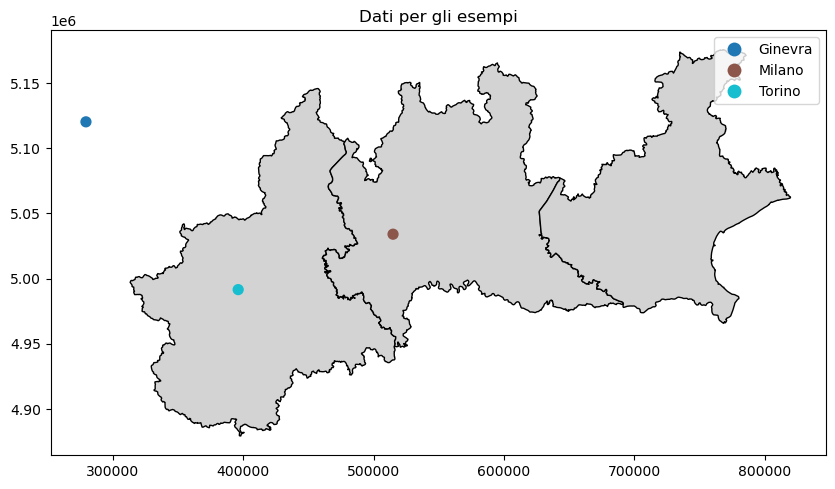

In [16]:
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt



# CRS 
print(f"CRS del dataset 'reg': {reg.crs}")


# Prepariamo alcuni GeoDataFrame per i test
lombardia = reg[reg.DEN_REG == "Lombardia"]
piemonte = reg[reg.DEN_REG == "Piemonte"]
veneto = reg[reg.DEN_REG == "Veneto"]


# Li creiamo in WGS84 (lat/lon) perché è facile trovarli
punti_wgs = gpd.GeoDataFrame(
    {
        "nome": ["Milano", "Torino", "Ginevra"],
        "geometry": [Point(9.19, 45.46), Point(7.68, 45.07), Point(6.14, 46.20)] 
    },
    crs="EPSG:4326"  # Specifichiamo che sono lat/lon
)

# Ora li convertiamo nello STESSO CRS dei nostri poligoni (reg)
punti_metric = punti_wgs.to_crs(reg.crs)

print(f"\nSetup completato. Dati in CRS: {reg.crs.name}")

# Visualizziamo i nostri dati di test
ax = reg[reg.DEN_REG.isin(["Lombardia", "Piemonte", "Veneto"])].plot(
    color="lightgrey", edgecolor="black", figsize=(10, 8)
)
punti_metric.plot(ax=ax, column='nome', legend=True, markersize=50)
plt.title("Dati per gli esempi")
plt.show()

### 6.2 Relazione - `intersects` 

In [17]:
# .iloc[0] estrae la geometria dalla prima (e unica) riga del GDF filtrato
geom_lomb = lombardia.geometry.iloc[0]
geom_piem = piemonte.geometry.iloc[0]
geom_veneto = veneto.geometry.iloc[0]

# La Lombardia e il Piemonte confinano, quindi si intersecano
print(f"Lombardia interseca Piemonte? {geom_lomb.intersects(geom_piem)}")

# Il Piemonte e il Veneto non confinano
print(f"Piemonte interseca Veneto?   {geom_piem.intersects(geom_veneto)}")

Lombardia interseca Piemonte? True
Piemonte interseca Veneto?   False


### 6.3 Relazione - `touches` 

In [18]:
geom_lomb = lombardia.geometry.iloc[0]
geom_piem = piemonte.geometry.iloc[0]

# Sono confinanti, quindi si "toccano"
print(f"Lombardia tocca Piemonte? {geom_lomb.touches(geom_piem)}")

# Un oggetto non può "toccare" sé stesso (si sovrappone)
print(f"Lombardia tocca sé stessa? {geom_lomb.touches(geom_lomb)}")

Lombardia tocca Piemonte? True
Lombardia tocca sé stessa? False


### 6.4 Relazione - `contains` / `within    `

In [19]:
geom_lomb = lombardia.geometry.iloc[0]
geom_milano = punti_metric[punti_metric.nome == "Milano"].geometry.iloc[0]
geom_torino = punti_metric[punti_metric.nome == "Torino"].geometry.iloc[0]

# Test 'contains'
print(f"Lombardia contiene Milano? {geom_lomb.contains(geom_milano)}")
print(f"Lombardia contiene Torino? {geom_lomb.contains(geom_torino)}")

# Test 'within'
print(f"Milano è dentro Lombardia? {geom_milano.within(geom_lomb)}")

Lombardia contiene Milano? True
Lombardia contiene Torino? False
Milano è dentro Lombardia? True


### 6.5 Operazione - Spatial Join `sjoin` 

In [20]:
# "how='left'" tiene tutti i punti, anche quelli che non trovano una regione
# "predicate='within'"  il punto deve essere 'dentro' il poligono
punti_con_regione = gpd.sjoin(punti_metric, reg, how="left", predicate="within")

print("Risultato dello Spatial Join:")
display(punti_con_regione)

# Nota come 'Ginevra' ha NaN (Not a Number) perché è fuori dall'Italia e non ha trovato corrispondenze.

Risultato dello Spatial Join:


,nome,geometry,index_right,COD_RIP,COD_REG,DEN_REG,SHAPE_LENG,SHAPE_AREA,SHAPE_LEN
0,Milano,POINT (514854.599 5034070.192),2.0,1.0,3.0,Lombardia,1.410209e+06,2.386241e+10,1.410209e+06
1,Torino,POINT (396090.572 4991574.041),0.0,1.0,1.0,Piemonte,1.235676e+06,2.539388e+10,1.235676e+06
2,Ginevra,POINT (279346.571 5120245.696),NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 6.6 Geoprocessing - `buffer` 

/tmp/ipykernel_62773/1184381129.py:11: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


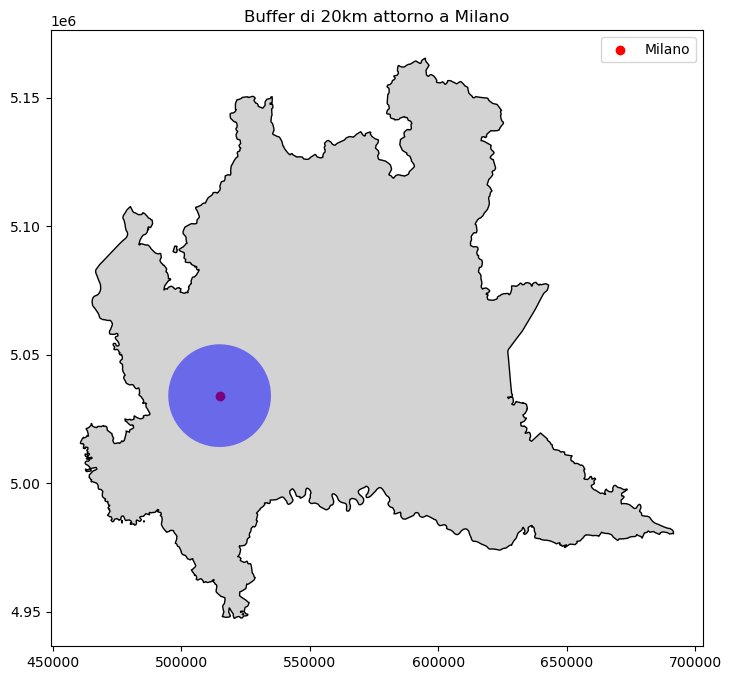

In [21]:
# Estraiamo il GDF di Milano
milano_gdf = punti_metric[punti_metric.nome == "Milano"]

# Creiamo un buffer di 20 km (20'000 metri)
buffer_milano = milano_gdf.buffer(20000) # 20km

# Visualizziamo
ax = lombardia.plot(color="lightgrey", edgecolor="black", figsize=(10, 8))
milano_gdf.plot(ax=ax, color="red", label="Milano")
buffer_milano.plot(ax=ax, color="blue", alpha=0.5, label="Buffer 20km")
ax.legend()
plt.title("Buffer di 20km attorno a Milano")
plt.show()

### 6.7 Geoprocessing - `overlay (intersection)` 

/tmp/ipykernel_62773/930317188.py:11: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()
/tmp/ipykernel_62773/930317188.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


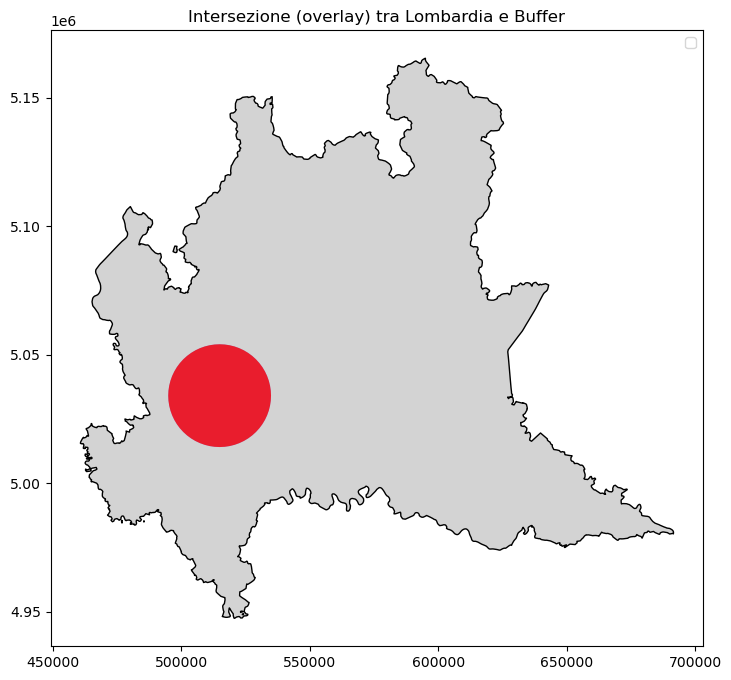

In [22]:
# Dobbiamo convertire la GeoSeries 'buffer_milano' in un GeoDataFrame
buffer_gdf = gpd.GeoDataFrame(geometry=buffer_milano, crs=reg.crs)

# Calcoliamo l'intersezione tra la Lombardia e il buffer
intersezione = gpd.overlay(lombardia, buffer_gdf, how="intersection")

# Visualizziamo
ax = lombardia.plot(color="lightgrey", edgecolor="black", figsize=(10, 8))
buffer_gdf.plot(ax=ax, color="blue", alpha=0.3, label="Buffer 20km")
intersezione.plot(ax=ax, color="red", alpha=0.8, label="Intersezione")
ax.legend()
plt.title("Intersezione (overlay) tra Lombardia e Buffer")
plt.show()

### 6.7 Geoprocessing - `overlay (difference)` 

/tmp/ipykernel_62773/1882031545.py:10: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()
/tmp/ipykernel_62773/1882031545.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


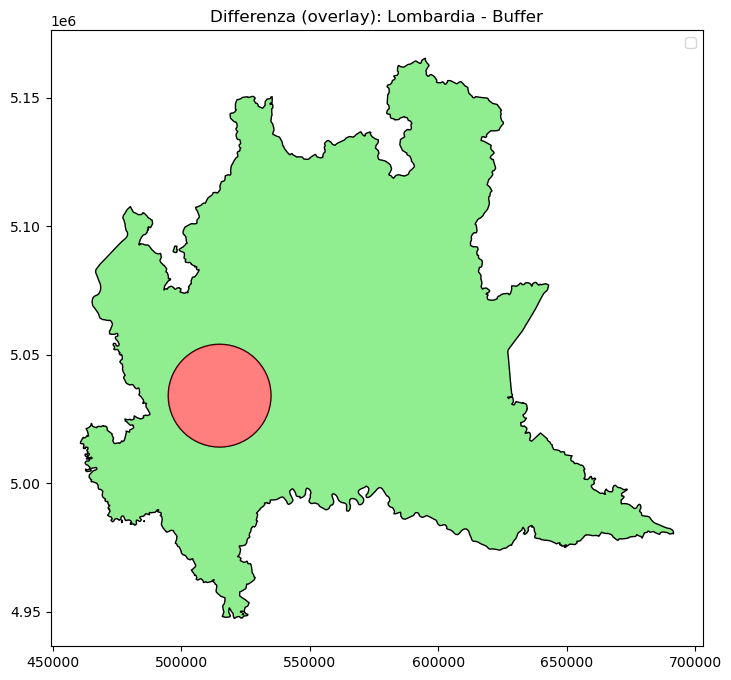

In [23]:
# Usiamo gli stessi dati di prima
buffer_gdf = gpd.GeoDataFrame(geometry=buffer_milano, crs=reg.crs)

# Calcoliamo la differenza: Lombardia MENO il buffer
differenza = gpd.overlay(lombardia, buffer_gdf, how="difference")

# Visualizziamo
ax = differenza.plot(color="lightgreen", edgecolor="black", figsize=(10, 8), label="Lombardia - Buffer")
buffer_gdf.plot(ax=ax, color="red", alpha=0.5, label="Buffer (sottratto)")
ax.legend()
plt.title("Differenza (overlay): Lombardia - Buffer")
plt.show()

### 6.7 Geoprocessing - `dissolve` 

Colonne disponibili: Index(['COD_RIP', 'COD_REG', 'DEN_REG', 'SHAPE_LENG', 'SHAPE_AREA',
       'SHAPE_LEN', 'geometry'],
      dtype='object')

GeoDataFrame 'dissolto' per COD_RIP:


,geometry,COD_REG,DEN_REG,SHAPE_LENG,SHAPE_AREA,SHAPE_LEN
COD_RIP,,,,,,
1,"MULTIPOLYGON (((437818.837 4875067.571, 437864...",1,Piemonte,1.235676e+06,2.539388e+10,1.235676e+06
2,"MULTIPOLYGON (((618312.929 4894034.66, 618329....",5,Veneto,1.056150e+06,1.834326e+10,1.056150e+06
3,"MULTIPOLYGON (((609456.687 4688695.322, 609466...",9,Toscana,1.306398e+06,2.298245e+10,1.306398e+06
4,"MULTIPOLYGON (((944910.242 4501010.871, 944916...",13,Abruzzo,6.156446e+05,1.082879e+10,6.156446e+05
5,"MULTIPOLYGON (((448987.897 4301665.251, 449000...",19,Sicilia,1.330374e+06,2.582290e+10,1.330374e+06


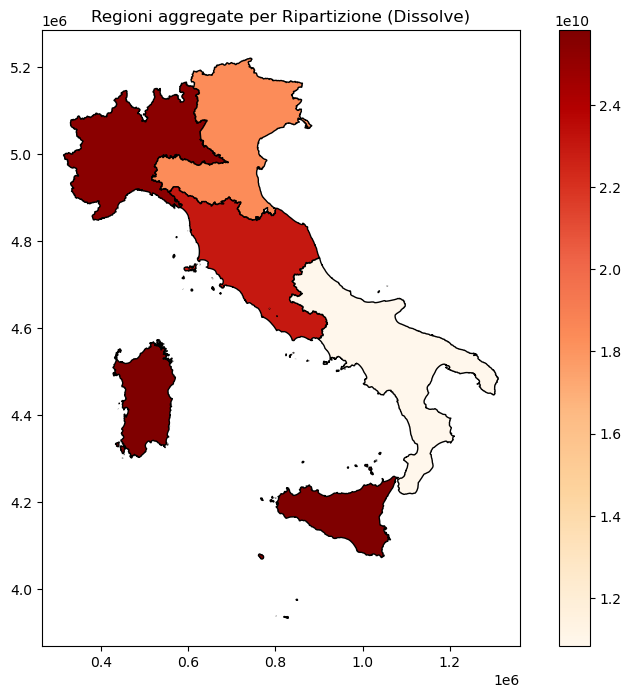

In [24]:
# Vogliamo creare le 4 "Macro-Aree" italiane (Nord-Ovest, Nord-Est, etc.)usando la colonna 'COD_RIP' (Codice Ripartizione)
print("Colonne disponibili:", reg.columns)

# Eseguiamo il dissolve
macro_aree = reg.dissolve(by="COD_RIP")

print("\nGeoDataFrame 'dissolto' per COD_RIP:")
display(macro_aree)

# Visualizziamo le macro-aree
macro_aree.plot(
    column="SHAPE_AREA", # Possiamo plottare un valore aggregato (somma aree)
    legend=True,
    figsize=(10, 8),
    cmap="OrRd",
    edgecolor="black"
)
plt.title("Regioni aggregate per Ripartizione (Dissolve)")
plt.show()

## 6.8 Esercizio Finale

Scenario: Vogliamo identificare tutti i comuni il cui territorio si trova, anche solo parzialmente, entro un raggio di 20 km dal centro di Torino. Inoltre, vogliamo sapere a quali province appartengono questi comuni.

In [25]:
import geopandas as gpd
import matplotlib.pyplot as plt

METRIC_CRS = "EPSG:25832"  # ETRS89 / UTM 32N 

def _to_metric_crs(gdf, crs=METRIC_CRS):
    if gdf.crs is None:
        raise ValueError("CRS mancante su un GeoDataFrame.")
    return gdf if gdf.crs.to_string() == crs else gdf.to_crs(crs)

def comuni_in_buffer(punti, nome_punto, com, prov, dist_km=20, metric_crs=METRIC_CRS):
    # CRS coerenti e metrici
    punti_m = _to_metric_crs(punti, metric_crs)
    com_m   = _to_metric_crs(com,   metric_crs)
    prov_m  = _to_metric_crs(prov,  metric_crs)

    # seleziona il punto richiesto (case-insensitive)
    mask = punti_m["nome"].str.casefold() == str(nome_punto).casefold()
    centro = punti_m.loc[mask]
    if centro.empty:
        raise ValueError(f"Punto '{nome_punto}' non trovato in 'punti'.")

    # buffer unico (in metri)
    buf_geom = centro.buffer(dist_km * 1000).unary_union
    buffer_gdf = gpd.GeoDataFrame(geometry=[buf_geom], crs=metric_crs)

    # pre-filtro per bbox (velocizza molto su dataset grandi)
    minx, miny, maxx, maxy = buffer_gdf.total_bounds
    com_bb = com_m.cx[minx:maxx, miny:maxy]

    # selezione comuni che INTERSECANO il buffer
    comuni_sel = gpd.sjoin(
        com_bb,
        buffer_gdf,
        how="inner",
        predicate="intersects",
        lsuffix="com",
        rsuffix="buf",
    ).drop(columns=["index_buf"], errors="ignore")

    # arricchimento provincia: se hai il codice provincia nei comuni, fai un merge, altrimenti un secondo sjoin
    if "COD_PROV" in comuni_sel.columns and "COD_PROV" in prov_m.columns:
        comuni_con_prov = comuni_sel.merge(
            prov_m[["COD_PROV", "DEN_PROV", "SIGLA"]],
            on="COD_PROV",
            how="left",
        )
    else:
        comuni_con_prov = gpd.sjoin(
            comuni_sel,
            prov_m[["COD_PROV", "DEN_PROV", "SIGLA", "geometry"]],
            how="left",
            predicate="within",
            lsuffix="com",
            rsuffix="prov",
        ).drop(columns=["index_prov"], errors="ignore")

    # elimina eventuali duplicati per codice ISTAT comune (adatta il campo se diverso)
    key = "PRO_COM" if "PRO_COM" in comuni_con_prov.columns else None
    if key:
        comuni_con_prov = comuni_con_prov.drop_duplicates(subset=key)

    return comuni_con_prov, buffer_gdf, centro


def plot_buffer(comuni_con_prov, buffer_gdf, centro, prov, dist_km=20, metric_crs=METRIC_CRS):
    prov_m = _to_metric_crs(prov, metric_crs)

    # Province presenti
    prov_ids_col = "COD_PROV"
    prov_ids = (
        comuni_con_prov[prov_ids_col].dropna().unique()
        if prov_ids_col in comuni_con_prov.columns
        else []
    )
    province_coinvolte = prov_m[prov_m[prov_ids_col].isin(prov_ids)] if len(prov_ids) else prov_m

    fig, ax = plt.subplots(figsize=(11, 11))
    province_coinvolte.plot(ax=ax, color="lightgrey", edgecolor="black", alpha=0.4)
    comuni_con_prov.plot(ax=ax, color="lightblue", edgecolor="grey", alpha=0.8)
    buffer_gdf.boundary.plot(ax=ax, linewidth=2, color="red")
    centro.plot(ax=ax, color="red", markersize=40)

    # etichetta del centro
    x, y = centro.geometry.iloc[0].x, centro.geometry.iloc[0].y
    nome = str(centro.iloc[0].get("nome", "centro"))
    ax.text(x + 2000, y + 2000, nome, color="red", fontsize=9)

    # inquadratura con padding
    minx, miny, maxx, maxy = buffer_gdf.total_bounds
    pad = max((maxx - minx), (maxy - miny)) * 0.2
    ax.set_xlim(minx - pad, maxx + pad)
    ax.set_ylim(miny - pad, maxy + pad)
    ax.set_title(f"Comuni che intersecano il buffer di {dist_km} km attorno a {nome}")
    ax.set_axis_off()
    plt.show()


/tmp/ipykernel_62773/1137464739.py:24: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buf_geom = centro.buffer(dist_km * 1000).unary_union


,COMUNE,DEN_PROV,SIGLA
83,Airasca,-,TO
0,Almese,-,TO
1,Alpignano,-,TO
2,Andezeno,-,TO
3,Arignano,-,TO
...,...,...,...
80,Volpiano,-,TO
81,Volvera,-,TO
84,Berzano di San Pietro,Asti,AT
85,Buttigliera d'Asti,Asti,AT


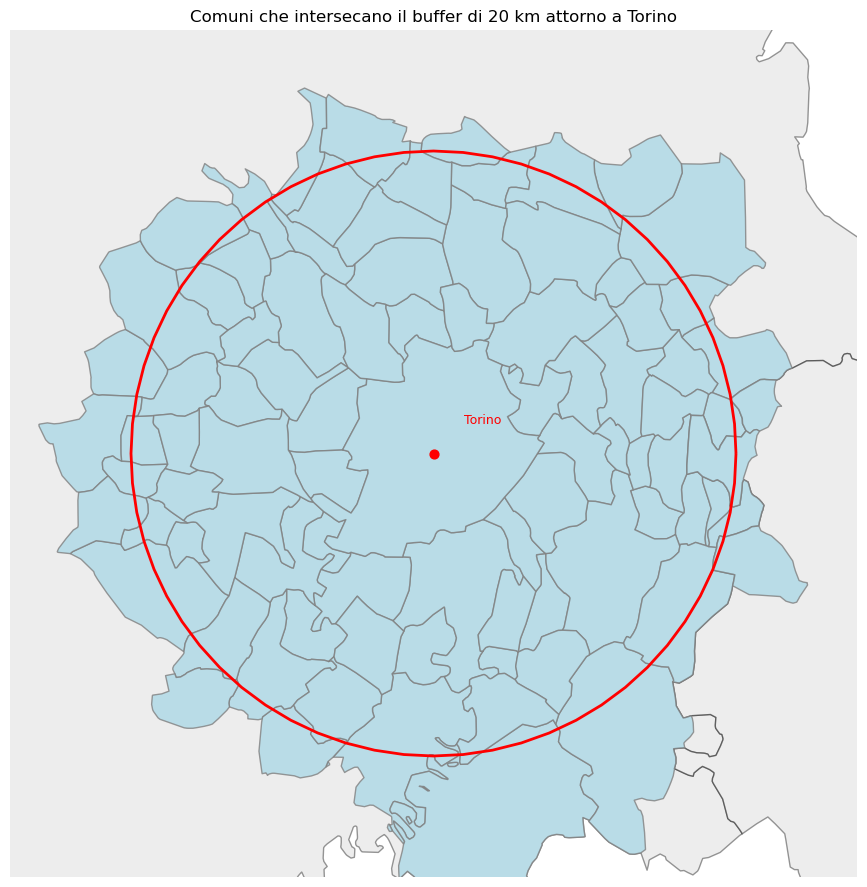

In [26]:
comuni_con_prov, buffer_gdf, centro = comuni_in_buffer(
    punti=punti_metric, nome_punto="Torino", com=com, prov=prov, dist_km=20
)
display(comuni_con_prov[["COMUNE", "DEN_PROV", "SIGLA"]].sort_values(["DEN_PROV", "COMUNE"]))

plot_buffer(comuni_con_prov, buffer_gdf, centro, prov=prov, dist_km=20)
